# Evaluation of RAG architectures

In [ ]:
from tqdm import tqdm
from pathlib import Path
from llms.clients.gpt import GPTClient
from llms.settings import settings
from llms.rag.faiss import DistanceMetric, FAISS
from llms.evaluation.code import evaluate_code_generation, ConfigGrid, RAG, RAGRetriever
from tests.pandas import TEST_CASES

In [ ]:
def get_texts(folder_paths: list[str]) -> list[str]:
    folder_paths = [Path(folder_path) for folder_path in folder_paths]
    files = []
    for folder_path in tqdm(folder_paths, desc="Searching for files"):
        for child in folder_path.iterdir():
            if child.is_file():
                files.append(child)
    texts = []
    for file in tqdm(files, desc="Reading files"):
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
            texts.append(content)
    return texts

In [ ]:
folder_paths = ["files/pandas/textfiles/textfiles1", "files/pandas/textfiles/textfiles2", "files/pandas/textfiles/textfiles3"]
texts = get_texts(folder_paths)

In [ ]:
gpt_4_client = GPTClient(
    client_id=settings.CLIENT_ID,
    client_secret=settings.CLIENT_SECRET,
    auth_url=settings.AUTH_URL,
    api_base=settings.API_BASE,
    deployment_id='gpt-4-32k',
    max_response_tokens=1000,
    temperature=0.0,
)

In [ ]:
# vector_store = FAISS.create_index_from_texts(
#     texts=texts,
#     llm_client=gpt_4_client,
#     distance_metric=DistanceMetric.MAX_INNER_PRODUCT,
#     num_search_results=3,
#     similarity_search_score_threshold=0.0,
#     text_chunk_size=512,
#     use_weighted_average_of_text_chunks=True,
# )

In [ ]:
# folder_path = "embeddings/semantic"
# filename = "embeddings_DistanceMetric.MAX_INNER_PRODUCT_search_results_3_score_threshold_0.0_chunk_size_512_weighted_average_True"
# vector_store.save_local(folder_path, filename)

In [ ]:
config_grid = ConfigGrid(
    llms=[gpt_4_client],
    rag=RAG(
        retrievers=[
            RAGRetriever.NONE,
            RAGRetriever.RAG,
            RAGRetriever.RAG_AS_TOOL,
            RAGRetriever.CoALA,
            RAGRetriever.CoALA_AS_TOOL,
        ],
        distance_metrics=[DistanceMetric.EUCLIDEAN_DISTANCE, DistanceMetric.MAX_INNER_PRODUCT],
        num_search_results=[3],
        similarity_search_score_thresholds=[0.0],
        text_chunk_sizes=[512],
        use_weighted_average_of_text_chunks=[True],
        texts=texts,
    )
)

In [ ]:
results = evaluate_code_generation(config_grid=config_grid, test_cases=TEST_CASES, test_name="pandas_updated_test_cases")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = "./results"
df = pd.read_csv(f"{path}/pandas_results.csv")

In [4]:
df = df.reset_index()
df

,index,config,accuracy,total_time,total_cost,details_csv_filepath
0,0,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.40,545.893470,20.423264,results/details/gpt-4-32k_RAGRetriever.RAG_Dis...
1,1,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.40,447.659310,21.386189,results/details/gpt-4-32k_RAGRetriever.CoALA_D...
2,2,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.35,348.562941,19.623164,results/details/gpt-4-32k_RAGRetriever.RAG_Dis...
3,3,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.35,430.342784,20.791775,results/details/gpt-4-32k_RAGRetriever.CoALA_D...
4,4,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.30,674.764801,22.992972,results/details/gpt-4-32k_RAGRetriever.CoALA_A...
5,5,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,223.853544,1.719149,results/details/gpt-4-32k_RAGRetriever.NONE_No...
6,6,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,424.385958,6.994267,results/details/gpt-4-32k_RAGRetriever.RAG_AS_...
7,7,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,438.385903,7.700234,results/details/gpt-4-32k_RAGRetriever.CoALA_A...
8,8,"{'llm': 'gpt-4-32k', 'retriever': <RAGRetrieve...",0.25,799.720272,18.199901,results/details/gpt-4-32k_RAGRetriever.RAG_AS_...


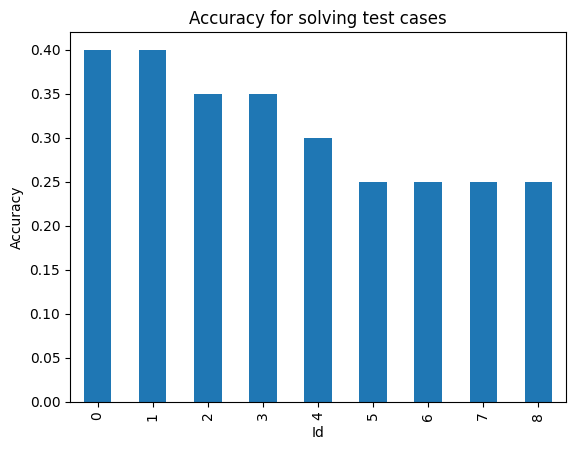

In [13]:
df.plot(kind='bar', x='index', y='accuracy', legend=False)
plt.title('Accuracy for solving test cases')
plt.xlabel('Id')
plt.ylabel('Accuracy')
plt.show()

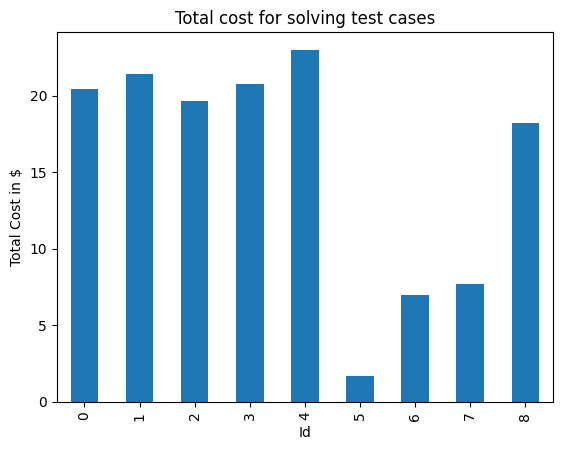

In [14]:
df.plot(kind='bar', x='index', y='total_cost', legend=False)
plt.title('Total cost for solving test cases')
plt.xlabel('Id')
plt.ylabel('Total Cost in $')
plt.show()

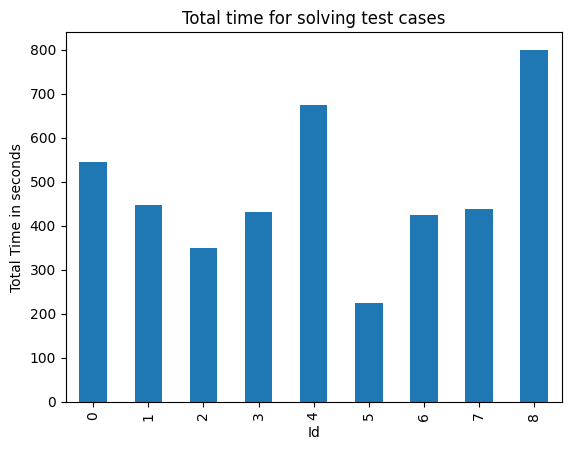

In [15]:
df.plot(kind='bar', x='index', y='total_time', legend=False)
plt.title('Total time for solving test cases')
plt.xlabel('Id')
plt.ylabel('Total Time in seconds')
plt.show()

In [9]:
details_path = df.iloc[0].details_csv_filepath
details_df = pd.read_csv(details_path)
details_df

,correct,time_taken,cost,test_case,test_case_output,test_case_input_data,generated_code,generated_code_output,agent_error,agent_reasoning
0,1,13.639109,0.703989,How can I convert this dataframe: df = pd.Data...,col1 col2\n0 a b\n1 b a\n2 a ...,"data = pd.DataFrame({""col1_a"": [1, 0, 1], ""col...",def response_function(df):\n import pandas ...,col1 col2\n0 a b\n1 b a\n2 a ...,NaN,[{'User prompt': 'How can I convert this dataf...
1,0,14.961737,0.802988,"This is my Dataframe:({'Name': ['Alice', 'Bob'...",Name Age Location\n100 Alice 25 ...,"data = pd.DataFrame({'Name': ['Alice', 'Bob', ...",def response_function(data):\n import panda...,NaN,0,"[{'User prompt': ""This is my Dataframe:({'Name..."
2,1,13.602790,0.789485,"({'animal': ['alligator', 'bee', 'falcon', 'li...",animal\n0 alligator\n1 bee\n2 ...,"data = pd.DataFrame({'animal': ['alligator', '...",def response_function(data):\n import panda...,animal\n0 alligator\n1 bee\n2 ...,NaN,"[{'User prompt': ""({'animal': ['alligator', 'b..."
3,1,14.620648,1.161303,ts = pd.Timestamp('2017-01-01 09:10:11') This ...,2017-03-01 09:10:11,data = pd.Timestamp('2017-01-01 09:10:11'),def response_function(ts):\n import pandas ...,2017-03-01 09:10:11,NaN,"[{'User prompt': ""ts = pd.Timestamp('2017-01-0..."
4,1,17.927339,1.915865,"ser = pd.Series([1, 2, 3, 4], index=['a', 'b',...",a 1.0\nb 3.0\nc 6.0\nd 10.0\ndt...,"data = pd.Series([1, 2, 3, 4], index=['a', 'b'...",def response_function(ser):\n import pandas...,a 1.0\nb 3.0\nc 6.0\nd 10.0\ndt...,NaN,"[{'User prompt': ""ser = pd.Series([1, 2, 3, 4]..."
5,1,16.389861,1.292591,"data1 = [[1, 8, 2], [1, 2, 5], [2, 5, 8], [2, ...",b c\na \n1 16 10\n2 30 72,"data_1 = [[1, 8, 2], [1, 2, 5], [2, 5, 8], [2,...","def response_function(data1, df):\n import ...",b c\na \n1 16 10\n2 30 72,NaN,"[{'User prompt': 'data1 = [[1, 8, 2], [1, 2, 5..."
6,0,13.572784,0.533048,"a = pd.Series([1, 1, 1, np.nan], index=['a', '...",a 1.0\nb inf\nc inf\nd 0.0\ne N...,"import numpy as np\ndata_1 = pd.Series([1, 1, ...","def response_function(a, b):\n import panda...",NaN,response_function() takes 2 positional argumen...,"[{'User prompt': ""a = pd.Series([1, 1, 1, np.n..."
7,0,15.896621,0.608829,"data = {('level_1', 'c', 'a'): [3, 7, 11],('le...",level_1 level_2 \n c d ...,"data = pd.DataFrame({('level_1', 'c', 'a'): [3...",def response_function(data):\n import panda...,level_1 level_2\n d f\n ...,NaN,"[{'User prompt': ""data = {('level_1', 'c', 'a'..."
8,0,15.175222,1.151524,Please take following Series and order it asce...,0 0 NaN\n1 1.0\n2 3.0\n3 10....,"import numpy as np\ndata = pd.Series([np.nan, ...",def response_function(s):\n import pandas a...,NaN,response_function() takes 1 positional argumen...,[{'User prompt': 'Please take following Series...
9,1,24.128649,1.576150,"data1 = {'Name': ['Alice', 'Bob', 'Charlie'],'...",23.5,"data_1 = {'Name': ['Alice', 'Bob', 'Charlie'],...","def response_function(data1, data2):\n impo...",23.5,NaN,"[{'User prompt': ""data1 = {'Name': ['Alice', '..."
